In [ ]:
!pip install arch

In [ ]:
import yfinance as yf
from arch.unitroot import ADF, KPSS
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from scipy import stats
import warnings

plt.rcParams["figure.figsize"] = (16, 9)  # Figure size and width

In [ ]:
data = yf.download("AAPL", start="2019-01-01", end='2024-12-31')
apple = data["Close"]

/tmp/ipython-input-2207327435.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2019-01-01", end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


In [ ]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2019-01-02 to 2024-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1509 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


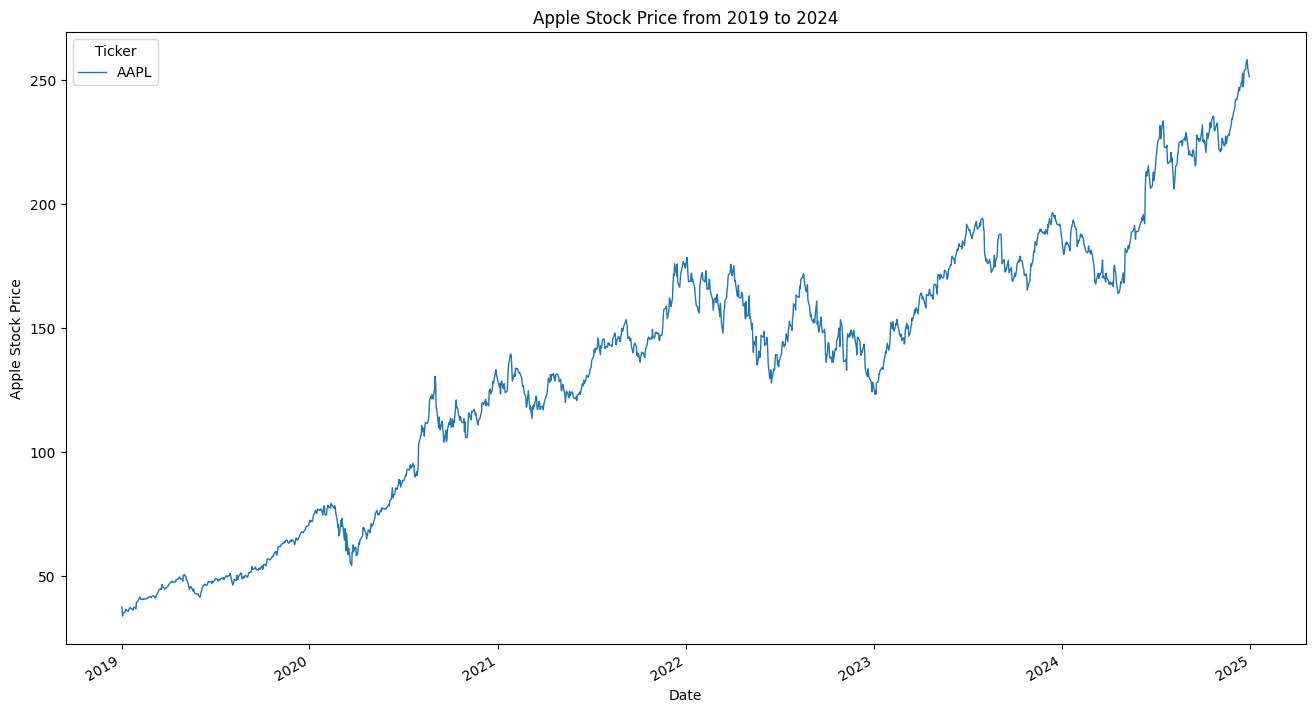

In [ ]:
# Plot Apple price time series chart
apple.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="Apple Stock Price",
    title="Apple Stock Price from 2019 to 2024",
)
plt.show()

In [ ]:
# Create an customized ADF test function similar to ut.df function from R
def ADF_test(data, test_type='none', maxlag=None, autolag='BIC'):
    """
    Perform Dickey-Fuller/Augmented Dickey-Fuller test with all relevant test statistics
    following the theoretical framework from Dickey and Fuller (1979)

    Parameters:
    - data: time series data (pandas Series or DataFrame)
    - test_type: 'none' (no constant, no trend), 'drift' (constant), 'trend' (constant + trend)
    - maxlag: maximum number of lags to test
    - autolag: method for automatic lag selection ('BIC', 'AIC', 't-stat')

    The three main versions:
    1) ∇x_t = γx_{t-1} + υ_t                           (test_type='none')
    2) ∇x_t = γx_{t-1} + α_0 + υ_t                    (test_type='drift')
    3) ∇x_t = γx_{t-1} + α_0 + α_2*t + υ_t           (test_type='trend')
    """

    # Clean and prepare data
    if hasattr(data, 'dropna'):
        clean_data = data.dropna()
    else:
        clean_data = pd.Series(data).dropna()

    # Extract values as 1D array
    if hasattr(clean_data, 'values'):
        y = clean_data.values.flatten()
    else:
        y = np.array(clean_data).flatten()

    # Map test_type to statsmodels regression parameter
    regression_map = {
        'none': 'n',    # no constant, no trend
        'drift': 'c',    # constant only
        'trend': 'ct'    # constant and trend
    }

    regression = regression_map[test_type]

    # Basic ADF test using statsmodels
    try:
        adf_result = adfuller(y, regression=regression, maxlag=maxlag, autolag=autolag)
        lags_used = adf_result[2]

        # Create basic result structure
        result = {
            'test_type': test_type,
            'model_equation': get_model_equation(test_type),
            'adf_statistic': adf_result[0],
            'adf_pvalue': adf_result[1],
            'lags_used': lags_used,
            'n_observations': adf_result[3],
            'critical_values': adf_result[4],
            'ic_best': adf_result[5] if len(adf_result) > 5 else None
        }

        # Try to add enhanced regression results and test statistics
        try:
            enhanced_results = calculate_enhanced_statistics(y, test_type, lags_used)
            result.update(enhanced_results)
        except Exception as e:
            # If enhanced calculation fails, just use basic ADF results
            result['enhancement_error'] = str(e)

        return result

    except Exception as e:
        return {
            'test_type': test_type,
            'error': f"ADF test failed: {str(e)}"
        }

def calculate_enhanced_statistics(y, test_type, lags_used):
    """Calculate enhanced test statistics (tau and phi) with proper regression"""

    # Create first differences and lagged level
    dy = np.diff(y)
    y_lag1 = y[:-1]

    # Handle lagged differences for ADF extension
    if lags_used > 0:
        # Create lagged differences
        lagged_diffs = []
        for lag in range(1, lags_used + 1):
            lagged_diffs.append(dy[:-lag])

        # Align all arrays to same length
        min_length = len(dy) - lags_used
        dy_final = dy[lags_used:][:min_length]
        y_lag1_final = y_lag1[lags_used:][:min_length]

        # Stack lagged differences and trim to match
        if lagged_diffs:
            lagged_dy = np.column_stack([ld[-min_length:] for ld in lagged_diffs])
        else:
            lagged_dy = None
    else:
        dy_final = dy
        y_lag1_final = y_lag1
        lagged_dy = None

    # Build regression matrix
    if test_type == 'none':
        # Model: ∇x_t = γx_{t-1} + υ_t
        if lagged_dy is not None:
            X = np.column_stack([y_lag1_final, lagged_dy])
            var_names = ['gamma'] + [f'dy_lag{i+1}' for i in range(lags_used)]
        else:
            X = y_lag1_final.reshape(-1, 1)
            var_names = ['gamma']

    elif test_type == 'drift':
        # Model: ∇x_t = γx_{t-1} + α_0 + υ_t
        if lagged_dy is not None:
            X = np.column_stack([np.ones(len(dy_final)), y_lag1_final, lagged_dy])
            var_names = ['alpha_0', 'gamma'] + [f'dy_lag{i+1}' for i in range(lags_used)]
        else:
            X = np.column_stack([np.ones(len(dy_final)), y_lag1_final])
            var_names = ['alpha_0', 'gamma']

    elif test_type == 'trend':
        # Model: ∇x_t = γx_{t-1} + α_0 + α_2*t + υ_t
        trend = np.arange(1, len(dy_final) + 1)
        if lagged_dy is not None:
            X = np.column_stack([np.ones(len(dy_final)), trend, y_lag1_final, lagged_dy])
            var_names = ['alpha_0', 'alpha_2', 'gamma'] + [f'dy_lag{i+1}' for i in range(lags_used)]
        else:
            X = np.column_stack([np.ones(len(dy_final)), trend, y_lag1_final])
            var_names = ['alpha_0', 'alpha_2', 'gamma']

    # Run OLS regression
    model = OLS(dy_final, X).fit()

    # Extract basic regression results
    coefficients = dict(zip(var_names, model.params))
    std_errors = dict(zip(var_names, model.bse))
    t_statistics = dict(zip(var_names, model.tvalues))
    p_values = dict(zip(var_names, model.pvalues))

    # Calculate test statistics
    test_statistics = {}

    if test_type == 'none':
        # τ₁ test: H₀: γ = 0
        gamma_t = t_statistics['gamma']
        test_statistics['tau1'] = {
            'statistic': gamma_t,
            'critical_value_5pct': -1.95,  # Approximate 5% critical value for τ₁
            'null_hypothesis': 'γ = 0 (unit root exists)',
            'alternative_hypothesis': 'γ ≠ 0 (stationary)',
            'interpretation': 'Tests for unit root in random walk model'
        }

    elif test_type == 'drift':
        # τ₂ test: H₀: γ = 0
        gamma_t = t_statistics['gamma']
        test_statistics['tau2'] = {
            'statistic': gamma_t,
            'critical_value_5pct': -2.86,  # Approximate 5% critical value for τ₂
            'null_hypothesis': 'γ = 0 (unit root exists)',
            'alternative_hypothesis': 'γ ≠ 0 (stationary)',
            'interpretation': 'Tests for unit root in random walk with drift model'
        }

        # φ₁ test: H₀: γ = 0 AND α₀ = 0
        try:
            R_matrix = np.array([[1, 0], [0, 1]])  # Test first two coefficients
            if lagged_dy is not None:
                R_full = np.zeros((2, len(coefficients)))
                R_full[:2, :2] = R_matrix
                R_matrix = R_full
            phi1_test = model.f_test(R_matrix)
            test_statistics['phi1'] = {
                'statistic': phi1_test.fvalue,
                'critical_value_5pct': 3.17,
                'null_hypothesis': 'γ = 0 AND α₀ = 0 (unit root AND no drift)',
                'alternative_hypothesis': 'γ ≠ 0 OR α₀ ≠ 0 (stationary OR drift exists)',
                'interpretation': 'Joint test for unit root and absence of constant'
            }
        except:
            test_statistics['phi1'] = {
                'statistic': np.nan,
                'error': 'F-test calculation failed'
            }

    elif test_type == 'trend':
        # τ₃ test: H₀: γ = 0
        gamma_t = t_statistics['gamma']
        test_statistics['tau3'] = {
            'statistic': gamma_t,
            'critical_value_5pct': -3.41,  # Approximate 5% critical value for τ₃
            'null_hypothesis': 'γ = 0 (unit root exists)',
            'alternative_hypothesis': 'γ ≠ 0 (stationary)',
            'interpretation': 'Tests for unit root in model with constant and trend'
        }

        # φ₂ test: H₀: γ = 0 AND α₀ = 0 AND α₂ = 0
        try:
            R_matrix = np.eye(3)  # Test first three coefficients
            if lagged_dy is not None:
                R_full = np.zeros((3, len(coefficients)))
                R_full[:3, :3] = R_matrix
                R_matrix = R_full
            phi2_test = model.f_test(R_matrix)
            test_statistics['phi2'] = {
                'statistic': phi2_test.fvalue,
                'critical_value_5pct': 4.68,
                'null_hypothesis': 'γ = 0 AND α₀ = 0 AND α₂ = 0 (unit root, no constant, no trend)',
                'alternative_hypothesis': 'At least one parameter ≠ 0',
                'interpretation': 'Joint test for unit root and absence of constant and trend'
            }
        except:
            test_statistics['phi2'] = {
                'statistic': np.nan,
                'error': 'F-test calculation failed'
            }

        # φ₃ test: H₀: γ = 0 AND α₀ = 0
        try:
            R_matrix = np.array([[1, 0, 0], [0, 0, 1]])  # Test constant and gamma
            if lagged_dy is not None:
                R_full = np.zeros((2, len(coefficients)))
                R_full[0, 0] = 1  # alpha_0
                R_full[1, 2] = 1  # gamma
                R_matrix = R_full
            phi3_test = model.f_test(R_matrix)
            test_statistics['phi3'] = {
                'statistic': phi3_test.fvalue,
                'critical_value_5pct': 3.17,
                'null_hypothesis': 'γ = 0 AND α₀ = 0 (unit root AND no constant)',
                'alternative_hypothesis': 'γ ≠ 0 OR α₀ ≠ 0 (stationary OR constant exists)',
                'interpretation': 'Joint test for unit root and absence of constant'
            }
        except:
            test_statistics['phi3'] = {
                'statistic': np.nan,
                'error': 'F-test calculation failed'
            }

    return {
        'test_statistics': test_statistics,
        'regression_results': {
            'coefficients': coefficients,
            'std_errors': std_errors,
            't_statistics': t_statistics,
            'p_values': p_values
        },
        'model_fit': {
            'r_squared': model.rsquared,
            'r_squared_adj': model.rsquared_adj,
            'fstatistic': model.fvalue,
            'f_pvalue': model.f_pvalue
        }
    }

def get_model_equation(test_type):
    """Return the model equation string for display"""
    equations = {
        'none': '∇x_t = γx_{t-1} + dy_lag(s) + υ_t',
        'drift': '∇x_t = γx_{t-1} + α_0 + dy_lag(s) + υ_t',
        'trend': '∇x_t = γx_{t-1} + α_0 + α_2*t + dy_lag(s) + υ_t'
    }
    return equations[test_type]

def print_dickey_fuller_summary(result):
    """Print comprehensive Dickey-Fuller test results"""

    print(f"\n{'='*80}")
    print(f"AUGMENTED-DICKEY-FULLER TEST RESULTS - {result['test_type'].upper()} MODEL")
    print(f"{'='*80}")

    # Check for errors
    if 'error' in result:
        print(f"ERROR: {result['error']}")
        return

    # Basic information
    print(f"Model: {result.get('model_equation', 'N/A')}")
    print(f"Lags Used: {result.get('lags_used', 'N/A')}")
    print(f"Number of Observations: {result.get('n_observations', 'N/A')}")
    if result.get('ic_best'):
        print(f"BIC: {result['ic_best']:.6f}")

    # Regression results
    if 'regression_results' in result:
        print(f"\n{'='*60}")
        print("REGRESSION RESULTS")
        print(f"{'='*60}")

        reg = result['regression_results']

        print(f"{'Parameter':<12} {'Coefficient':<12} {'Std Error':<12} {'t-statistic':<12} {'p-value':<12}")
        print("-" * 68)

        for param in reg['coefficients'].keys():
            coef = reg['coefficients'][param]
            se = reg['std_errors'][param]
            t_stat = reg['t_statistics'][param]
            p_val = reg['p_values'][param]

            marker = " ← γ (unit root)" if param == 'gamma' else ""
            print(f"{param:<12} {coef:<12.6f} {se:<12.6f} {t_stat:<12.6f} {p_val:<12.6f}{marker}")

        # Model fit
        if 'model_fit' in result:
            fit = result['model_fit']
            print(f"\nModel Fit:")
            print(f"  R-squared: {fit['r_squared']:.6f}")
            print(f"  Adjusted R-squared: {fit['r_squared_adj']:.6f}")
            print(f"  F-statistic: {fit['fstatistic']:.6f}")


    # Enhanced test statistics
    if 'test_statistics' in result:
        print(f"\n{'='*60}")
        print("DETAILED TEST STATISTICS")
        print(f"{'='*60}")

        for test_name, test_info in result['test_statistics'].items():
            print(f"\n{test_name.upper()} Test:")

            if 'error' in test_info:
                print(f"  Error: {test_info['error']}")
                continue

            print(f"  H₀: {test_info['null_hypothesis']}")
            print(f"  H₁: {test_info['alternative_hypothesis']}")

            stat_val = test_info['statistic']
            print(f"  Test Statistic: {stat_val:.6f}")

            # Handle critical values for both tau and phi tests
            if 'critical_value_5pct' in test_info:
                crit_val = test_info['critical_value_5pct']
                print(f"  5% Critical Value: {crit_val}")

                # Decision logic for tau tests (left-tail test)
                if 'tau' in test_name:
                    if stat_val < crit_val:
                        print(f"  Decision: Reject H₀ (t-stat < critical value)")

                    else:
                        print(f"  Decision: Fail to reject H₀ (t-stat > critical value)")


                # Decision logic for phi tests (right-tail test)
                elif 'phi' in test_name:
                    if stat_val > crit_val:
                        print(f"  Decision: Reject H₀ (F-stat > critical value)")

                    else:
                        print(f"  Decision: Fail to reject H₀ (F-stat < critical value)")

In [ ]:
# Apple Stock Price, ADF Test without Drift and Trend
df_apple_none = ADF_test(apple, test_type='none', autolag='BIC')
print_dickey_fuller_summary(df_apple_none)


AUGMENTED-DICKEY-FULLER TEST RESULTS - NONE MODEL
Model: ∇x_t = γx_{t-1} + dy_lag(s) + υ_t
Lags Used: 0
Number of Observations: 1508
BIC: 6890.936715

REGRESSION RESULTS
Parameter    Coefficient  Std Error    t-statistic  p-value     
--------------------------------------------------------------------
gamma        0.000831     0.000434     1.913250     0.055905     ← γ (unit root)

Model Fit:
  R-squared: 0.002423
  Adjusted R-squared: 0.001761
  F-statistic: 3.660526

DETAILED TEST STATISTICS

TAU1 Test:
  H₀: γ = 0 (unit root exists)
  H₁: γ ≠ 0 (stationary)
  Test Statistic: 1.913250
  5% Critical Value: -1.95
  Decision: Fail to reject H₀ (t-stat > critical value)


In [ ]:
# ADF test with drift but no trend
df_apple_drift = ADF_test(apple, test_type='drift', autolag='BIC')
print_dickey_fuller_summary(df_apple_drift)


AUGMENTED-DICKEY-FULLER TEST RESULTS - DRIFT MODEL
Model: ∇x_t = γx_{t-1} + α_0 + dy_lag(s) + υ_t
Lags Used: 0
Number of Observations: 1508
BIC: 6896.694177

REGRESSION RESULTS
Parameter    Coefficient  Std Error    t-statistic  p-value     
--------------------------------------------------------------------
alpha_0      0.216323     0.169424     1.276815     0.201864    
gamma        -0.000554    0.001168     -0.474221    0.635411     ← γ (unit root)

Model Fit:
  R-squared: 0.000149
  Adjusted R-squared: -0.000515
  F-statistic: 0.224885

DETAILED TEST STATISTICS

TAU2 Test:
  H₀: γ = 0 (unit root exists)
  H₁: γ ≠ 0 (stationary)
  Test Statistic: -0.474221
  5% Critical Value: -2.86
  Decision: Fail to reject H₀ (t-stat > critical value)

PHI1 Test:
  H₀: γ = 0 AND α₀ = 0 (unit root AND no drift)
  H₁: γ ≠ 0 OR α₀ ≠ 0 (stationary OR drift exists)
  Test Statistic: 2.646157
  5% Critical Value: 3.17
  Decision: Fail to reject H₀ (F-stat < critical value)


In [ ]:
# ADF test with drift and trend
df_apple_trend = ADF_test(apple, test_type='trend', autolag='BIC')
print_dickey_fuller_summary(df_apple_trend)


AUGMENTED-DICKEY-FULLER TEST RESULTS - TREND MODEL
Model: ∇x_t = γx_{t-1} + α_0 + α_2*t + dy_lag(s) + υ_t
Lags Used: 0
Number of Observations: 1508
BIC: 6897.190667

REGRESSION RESULTS
Parameter    Coefficient  Std Error    t-statistic  p-value     
--------------------------------------------------------------------
alpha_0      0.564259     0.214603     2.629319     0.008643    
alpha_2      0.001240     0.000471     2.632970     0.008551    
gamma        -0.010084    0.003803     -2.651856    0.008089     ← γ (unit root)

Model Fit:
  R-squared: 0.004734
  Adjusted R-squared: 0.003411
  F-statistic: 3.579152

DETAILED TEST STATISTICS

TAU3 Test:
  H₀: γ = 0 (unit root exists)
  H₁: γ ≠ 0 (stationary)
  Test Statistic: -2.651856
  5% Critical Value: -3.41
  Decision: Fail to reject H₀ (t-stat > critical value)

PHI2 Test:
  H₀: γ = 0 AND α₀ = 0 AND α₂ = 0 (unit root, no constant, no trend)
  H₁: At least one parameter ≠ 0
  Test Statistic: 4.081898
  5% Critical Value: 4.68
  Decisi